## Установка зависимостей

In [1]:
# !pip install -r requirements1.txt

скачать папку с датасетом [тут](https://drive.google.com/file/d/1RjclDOmrO3AbFwvtYIM_bROaNgycNEzw/view?usp=share_link)

## Блок импорта

In [2]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset

import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split

from pathlib import Path
from yaml import load, Loader

from torch_lr_finder import LRFinder
from src.dataset import CustomImageDataset, label_builder
from src.augs import train_augs, valid_augs, AugmentedDataset
from src.model_builder import Model
import shutup; shutup.please()

## Задача

Здрасте-здрасте, с вами Даня Крастер (нет), и сегодня мы решаем задачу классификации с помощью сверточных нейронных сетей - отличаем коричневые автомобили от оранжевых.

Думаю, будет интересно!

## Преднастройки

### Конфиг 

Из YAML-файла подцепляем параметры конфигурации нашего обучения. На будущее рекомендую научиться использовать hydra, отличная штука.

Изучите конфиг, посмотрите, что за что отвечает. В комментарии ниже это помечено =)

In [3]:
with open('config.yml') as f:
    globals().update(load(f, Loader=Loader))

In [4]:
# CLASSES = ('brown', 'red')
# IMG_DIR = 'imgs'
# IMG_SIZE = 224
# BATCH_SIZE = 10
# EPOCHS = 40
# LR = 5e-4 learning rate
# GAMMA = 0.25 коэффициент убывания learning rate
# ES_PATIENCE = 8 число раз, которые validation loss должно не уменшиться, чтобы закончить обучение досрочно
# SEED = 42

### Устройство 

Постараемся обучаться на GPU, если имеется видеокарта NVIDIA и установлен CUDA toolkit. Задачи такого уровня еще можно кое-как решать на процессоре, но это будет оче медленно.

Для ЛЕГКОЙ установки CUDA на компьютер КРАЙНЕ рекомендую воспользоваться Анакондой, и ставить pytorch через анакондовский загрузчик посредством следующей команды в отдельно созданной в Анаконде же виртуальной среде:
conda install pytorch torchvision pytorch-cuda=11.6 -c pytorch -c nvidia

Остальное из requirements можно ставить через pip.

Вышеуказанный способ РЕАЛЬНО проще, чем долбаться с совместимостью любым другим образом.

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
device

device(type='cuda')

In [6]:
torch.cuda.empty_cache()

### Воспроизводимость 

Фиксируем рандомизацию. Всегда можно поменять.

In [7]:
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True 
seed_everything(SEED=SEED)

## Подготовка

В этом разделе мы загружаем предварительно размеченные данные и создаем пайторчевские датасеты - особые итерируемые объекты, выдающие данные уже в пригодном для засовывания в нейросеть формате, и упакованными в батчи заданного размера. Все нужные функции и классы лежат в папке src, очень рекомендую ознакомиться с тем, как они устроены.

In [8]:
root = Path('.')
imgs = root / IMG_DIR
img_labels = label_builder(CLASSES, imgs)

In [9]:
data = CustomImageDataset(img_labels)

In [10]:
# посмотрим на картиночки
def imgshow(img):
    # обратно
    img = img + 0.5
    # отображение матплотлиба с разворотом
    plt.imshow(np.transpose(img,(1,2,0)))
    plt.show()

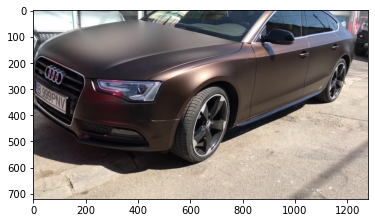

In [11]:
plt.imshow(data[0][0]);

### Разбиение

Здесь, в общем, все как в классическом машинном обучении, например, работе с градиентным бустингом.

In [12]:
# стратифицированное разбиение выборки на обучающую и тестовую
train_ind, test_ind = train_test_split(range(len(data)), stratify=data.img_labels.label, test_size=0.1, random_state=42)

trainset = Subset(data, train_ind)
testset = Subset(data, test_ind)

woo = trainset.dataset.img_labels.iloc[train_ind].label

# стратифицированное разбиение обучающей выборки на обучающую и валидационную
train_ind, valid_ind, _, _ = train_test_split(train_ind, woo, stratify=woo, test_size=1/9, random_state=13)

trainset = Subset(data, train_ind)
validset = Subset(data, valid_ind)

### Преобразование

Добавляем **аугментации** - способ искусственно расширить датасет, чуть-чуть испортив исходные картинки дырками, сдвигами, поворотами и прочим. Так обучение сети будет более полным, и помогает в том случае, если не хватает данных для обучения. 

Аугментации применяются **на ходу**, при загрузке изображения с диска, в цифровом виде. Причем применяются они с некоторой заданной вероятностью, т.е. картинка может уйти в обучение в исходном виде, а может в аугментированном. Прогоняя датасет некоторое количество эпох, мы подаем сети и исходные изображения, и их испорченные варианты **с той же меткой**. Так она учится лучше!

Наилучшая сейчас библиотека самых разных аугментаций - Albumentations. Ее мы и применяем здесь.

Подробнее смотреть в src/augs.py

In [13]:
trainset = AugmentedDataset(trainset, aug=train_augs(IMG_SIZE))
validset = AugmentedDataset(validset, aug=valid_augs(IMG_SIZE))
testset = AugmentedDataset(testset, aug=valid_augs(IMG_SIZE))
len(trainset), len(validset), len(testset)

(1276, 160, 160)

Размеры обучающего, валидационного и тестового наборов подтвержены.

### Итераторы наборов данных

С помощью этих конструкций датасеты передаются уже в нейросеть по батчам заданного размера. Параметр shuffle подает батчи в случайном порядке, если включен.

In [14]:
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

## Обучение

Устройство модели смотрим в src/model_builder.py. 
Для такой несложной задачи, как классификация машин по цвету, достаточно архитектуры, похожей на LeNet, с поправкой на современные реалии в виде активации ReLU, дропаута и батч-нормализации.

In [15]:
car_class = Model('CarCrash', device, train_loader, valid_loader, test_loader, CLASSES)
car_class.create_optim(LR, gamma=GAMMA)

### Оценка learning rate

Попробуем оценить оптимальную стартовую скорость обучения с помощью LRfinder

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.97E-03


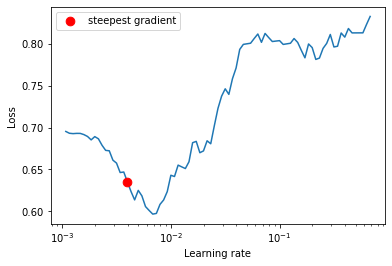

In [16]:
lr_finder = LRFinder(car_class.net, car_class.test_opt, car_class.net.loss, device="cuda")
lr_finder.range_test(train_loader, end_lr=1, num_iter=100)
lr_finder.plot() 
lr_finder.reset() # cбросим модель и оптимизатор

С практической точки зрения имеет смысл взять LR чуть меньше, чем чем найденный оптимум. В нашем конфиге стоит LR=5e-4, поэтому в данном случае нет причин что-то менять здесь и сейчас. 

Начинаем обучение. В любой момент его можно приостановить кнопкой stop и играть с недообученной сетью. 

Само по себе обучение закончится или когда все эпохи из EPOCHS будут завершены, или когда Validation Loss не будет уменьшаться количество раз, заданное параметром ES_PATIENCE. К примеру, если ES_PATIENCE = 4, то обучение останавливается, если в течение 4 эпох Validation Loss не падает.

In [17]:
# Training
car_class.train(EPOCHS, esp=ES_PATIENCE, verbose=True)

,Train loss,Validation loss,"Training time, s","Validation time, s",Learning rate
epoch,,,,,
1,0.522608,0.406624,48.826518,4.341884,5.000000e-04
2,0.397178,0.378534,47.969342,4.422892,5.000000e-04
3,0.386968,0.377378,48.135095,4.270028,5.000000e-04
4,0.378496,0.366411,48.058692,4.289762,5.000000e-04
5,0.374552,0.368716,48.341558,4.330909,5.000000e-04
6,0.359770,0.359984,48.383684,4.358585,1.250000e-04
7,0.366296,0.385230,48.245245,4.313189,1.250000e-04
8,0.362652,0.358699,48.455182,4.304302,3.125000e-05
9,0.359783,0.357964,48.374834,4.366111,3.125000e-05


KeyboardInterrupt: 

Внимательно сравните столбец убывания Validation Loss и Learning rate. Последний падает на скачках первого - именно так и работает LR-scheduler с условием. Мы искусственно снижаем learning rate, если сеть попадает в локальный максимум функции потерь.

## Проверка

Возьмем первые 10 картинок из тестового набора и прогоним через обученную сеть, чтобы убедиться, что она работает, и как работает.

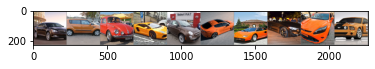

In [18]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
imgshow(torchvision.utils.make_grid(images, nrow=BATCH_SIZE))

Сравним заданные и предсказанные метки классов!

In [19]:
_, predicted = torch.max(car_class.net(images.cuda()), 1)
print('Исходные метки:      ', ' '.join(f'{CLASSES[labels[j]]:6s}' for j in range(10)))
print('Предсказанные метки: ', ' '.join(f'{CLASSES[predicted[j]]:6s}'for j in range(10)))

Исходные метки:       brown  orange orange orange brown  orange orange brown  orange orange
Предсказанные метки:  brown  brown  orange orange brown  orange orange orange orange orange


И немного метрик тоже не помешает, точно также, как и матрица неточностей:

Accuracy: 0.9625, Precision: 0.9615384615384616, Recall: 0.9615384615384616


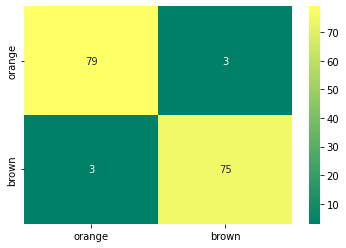

In [20]:
car_class.eval()

Надо заметить, что задача не самая простая из всех, так как оранжевый и коричневый цвета довольно близки друг к другу. К примеру, классификация красных и зеленых машин прошла бы куда лучше. Но ведь это и интересно!

Попробуйте собрать свой собственный датасет классификации, разметить его по аналогии с этим, назвать классы - и обучить такую же сеть на своих любимых объектах!

Лучше всего иметь около 1000 изображений каждого класса, 700-800 тоже пойдет, если применять аугментации.

Для автоматического поиска изображений, чтобы не качать ручками, рекомендую использовать поисковик DuckDuckGO и скрипт с сайта FastAI.

Дерзайте!